# Learned Image Compression (LIC)


In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
# this one works

import torch
import torchvision.transforms as transforms
from PIL import Image
from compressai.zoo import models
import os
from datetime import datetime

def compress_image_with_pretrained(img, quality=1, output_prefix=""):
    """
    Compress an image using a pre-trained CompressAI model
    """
    # img = Image.open(image_path).convert('RGB')
    
    # Load model
    model = models['bmshj2018-factorized'](quality=quality, pretrained=True)
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Transform and pad
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    _, _, h, w = x.shape
    pad_h = (64 - (h % 64)) % 64
    pad_w = (64 - (w % 64)) % 64
    
    if pad_h > 0 or pad_w > 0:
        x = torch.nn.functional.pad(x, (0, pad_w, 0, pad_h))
    
    # Compress and decompress
    with torch.no_grad():
        compressed = model.compress(x)
        decompressed = model.decompress(compressed['strings'], compressed['shape'])
    
    # Post-process
    x_hat = decompressed['x_hat']
    if pad_h > 0 or pad_w > 0:
        x_hat = x_hat[:, :, :h, :w]
    
    # Convert to PIL Image
    out_img = transforms.ToPILImage()(x_hat.squeeze().cpu().clamp_(0, 1))
    
    # Calculate stats
    original_size = img.size
    # os.path.getsize(image_path)
    compressed_size = sum(len(s[0]) for s in compressed['strings'])
    
    # Save the output
    output_filename = f"{output_prefix}_q{quality}.png"
    out_img.save(output_filename)
    
    return {
        'quality': quality,
        'original_size_bytes': original_size,
        'compressed_size_bytes': compressed_size,
        'compression_ratio': original_size / compressed_size,
        'output_file': output_filename
    }

def compare_quality_levels(img, qualities=[1, 4, 6, 8]):
    """
    Compare different quality levels of compression
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_prefix = f"compressed"
    
    results = []
    print("\nProcessing different quality levels:")
    print("-" * 60)
    print(f"{'Quality':<8} {'Original':<12} {'Compressed':<12} {'Ratio':<8}")
    print("-" * 60)
    
    for quality in qualities:
        result = compress_image_with_pretrained(
            img, 
            quality=quality,
            output_prefix=output_prefix
        )
        results.append(result)
        
        print(f"{quality:<8} "
              f"{result['original_size_bytes']/1024:>8.2f} KB "
              f"{result['compressed_size_bytes']/1024:>8.2f} KB "
              f"{result['compression_ratio']:>8.2f}x")
    
    print("-" * 60)
    print(f"\nOutput files saved with prefix: {output_prefix}")
    return results

# results = compare_quality_levels('0.png')

In [8]:
from keras.datasets import cifar10
(x_train, _), (x_test, _) = cifar10.load_data()


In [9]:
# Convert the first 5 test images to grayscale
from skimage.color import rgb2gray
import numpy as np
sample_images = x_test[:5]
# sample_images_gray = np.array([rgb2gray(img) for img in sample_images])


In [17]:
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(original, compressed):
    # def decode_binary_to_image(binary_string, shape):
    #     # Split binary string into 8-bit chunks
    #     byte_array = bytes(int(binary_string[i:i+8], 2) for i in range(0, len(binary_string), 8))
        
    #     # Convert byte array into a NumPy array and reshape to the original image shape
    #     decompressed_image = np.frombuffer(byte_array, dtype=np.uint8).reshape(shape)
    #     return decompressed_image
    
    # compressed = decode_binary_to_image(compressed)
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')  # No error means infinite PSNR
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

# Function to calculate SSIM
def calculate_ssim(original, compressed):
    return ssim(
        original, 
        compressed, 
        multichannel=True, 
        data_range=compressed.max() - compressed.min(),
        win_size=7, channel_axis=2
    )
    



Processing different quality levels:
------------------------------------------------------------
Quality  Original     Compressed   Ratio   
------------------------------------------------------------
1            3.00 KB     0.07 KB    40.42x
4            3.00 KB     0.22 KB    13.71x
6            3.00 KB     0.42 KB     7.18x
8            3.00 KB     0.72 KB     4.15x
------------------------------------------------------------

Output files saved with prefix: compressed

Processing different quality levels:
------------------------------------------------------------
Quality  Original     Compressed   Ratio   
------------------------------------------------------------
1            3.00 KB     0.07 KB    40.42x
4            3.00 KB     0.20 KB    15.36x
6            3.00 KB     0.37 KB     8.08x
8            3.00 KB     0.62 KB     4.83x
------------------------------------------------------------

Output files saved with prefix: compressed

Processing different quality levels:


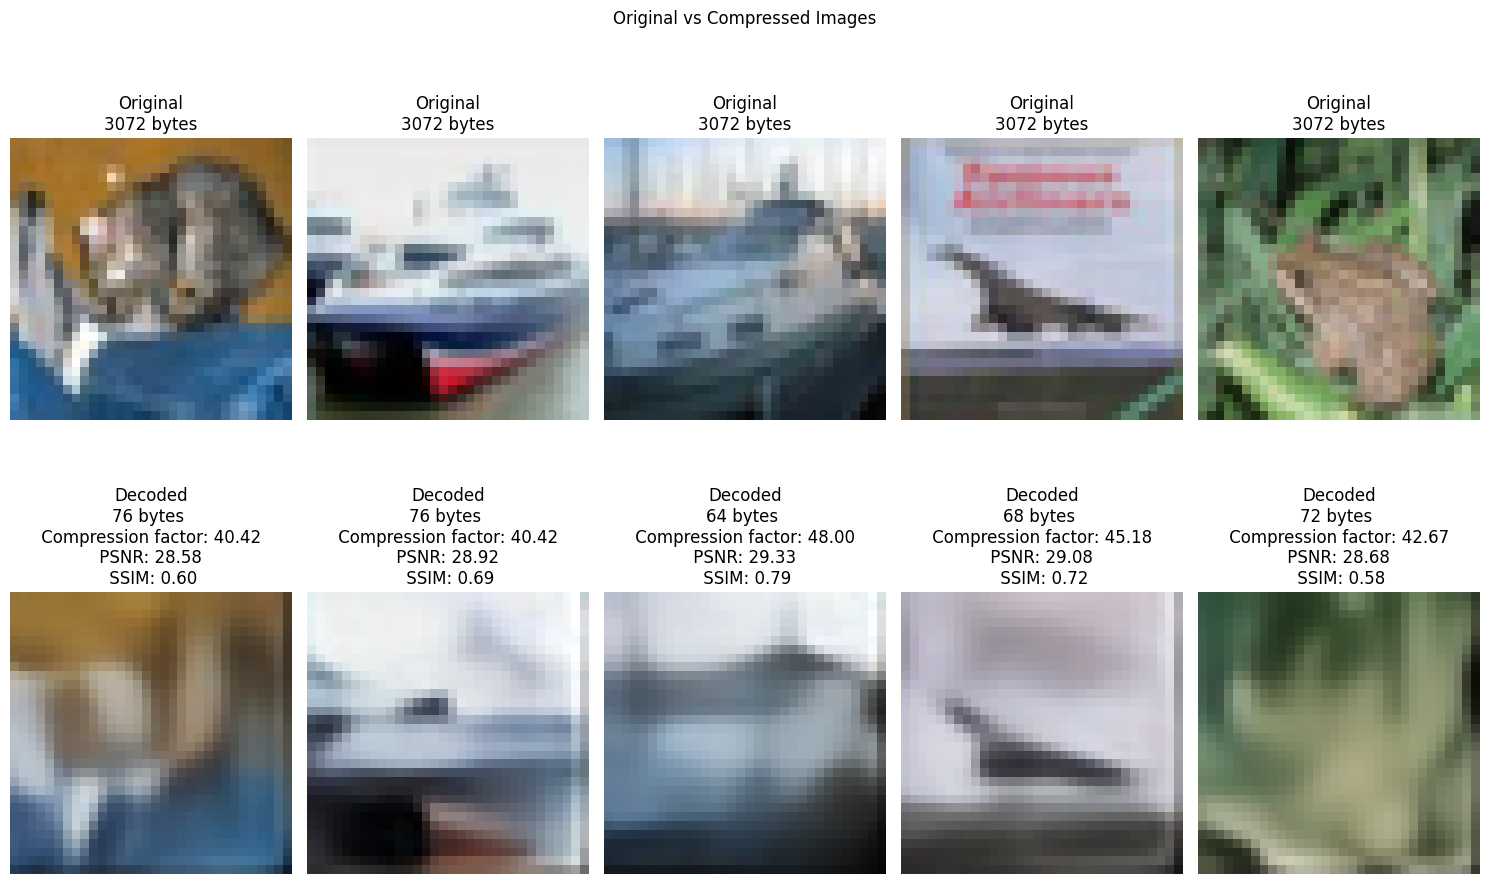

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

for i, img in enumerate(sample_images):
    # encoded_image, tree, shape = huffman_encoding(img)
    # decoded_image = huffman_decoding(encoded_image, tree, shape)
    # compression_factor = img.nbytes / (len(encoded_image)//8)
    results = compare_quality_levels(img)
    
    decoded_image = Image.open(results[0]['output_file']).convert('RGB')
    
    psnr = calculate_psnr(img, np.array(decoded_image))
    ss = calculate_ssim(img, np.array(decoded_image))
    
    plt.subplot(2, len(sample_images), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{results[0]['original_size_bytes']} bytes")
    plt.axis('off')

    plt.subplot(2, len(sample_images), i + 1 + len(sample_images))
    plt.imshow(decoded_image, cmap='gray')
    plt.title(f"Decoded\n{results[0]['compressed_size_bytes']} bytes \n Compression factor: {results[0]['compression_ratio']:.2f} \n PSNR: {psnr:.2f} \n SSIM: {ss:.2f}")
    plt.axis('off')

plt.suptitle(f"Original vs Compressed Images")
plt.tight_layout()
plt.show()